In [2]:
from IPython.display import Image
import numpy as np
import pandas
import cv2
from datetime import datetime
import keras
import itertools
import warnings
warnings.filterwarnings("ignore")

Зчитуєм дані

In [3]:
test_data = pandas.read_csv('Test_Data150.csv')
test_data.drop(['Unnamed: 0'], axis = 1, inplace = True)
print(test_data.shape)

(150, 2)


In [4]:
test_data.head()

,ImageName,Labels
0,SynthImageDataset/3000/7/182_slinking_71711.jpg,SLINKING
1,SynthImageDataset/3000/7/181_REMODELERS_64541.jpg,REMODELERS
2,SynthImageDataset/3000/7/180_Chronographs_1353...,CHRONOGRAPHS
3,SynthImageDataset/3000/7/179_Impeaching_38222.jpg,IMPEACHING
4,SynthImageDataset/3000/7/177_Loots_45256.jpg,LOOTS


Допоміжні функції

In [5]:
#Letters present in the Label Text
letters = '0123456789ABCDEFGHIJKLMNOPQRSTUVWXYZ'

In [6]:
def words_from_labels(labels):
    """
    converts the list of encoded integer labels to word strings like eg. [12,10,29] returns CAT 
    """
    txt=[]
    for ele in labels:
        if ele == len(letters): # CTC blank space
            txt.append("")
        else:
            txt.append(letters[ele])
    return "".join(txt)

In [7]:
def decode_label(out):
    """
    Takes the predicted ouput matrix from the Model and returns the output text for the image
    """
    # out : (1, 48, 37)
    out_best = list(np.argmax(out[0,2:], axis = 1))

    out_best = [k for k, g in itertools.groupby(out_best)]  # remove overlap value

    outstr=words_from_labels(out_best)
    return outstr

In [8]:
#image height
img_h = 32
#image width
img_w = 170
#image Channels
img_c = 1
# classes for softmax with number of letters +1 for blank space in ctc
num_classes = len(letters) + 1
batch_size = 64
max_length = 15 # considering max length of ground truths labels to be 15

Функція для передбачення тексту на 1 картинці

In [9]:
def single_image_Prediction(model, img_path):
    """
    Takes the best model, test data image paths, test data groud truth labels and pre-processes the input image to 
    appropriate format for the model prediction, takes the predicted output matrix and uses best path decoding to 
    generate predicted text and prints the Predicted Text Label, Time Taken for Computation
    """
    start = datetime.now()
    img = cv2.imread(img_path)
    img_resized = cv2.resize(img, (170,32))
    img = img_resized[:,:,1]
    img = img.T 
    img = np.expand_dims(img,axis=-1)
    img = np.expand_dims(img, axis=0)
    img = img/255
    model_output = model.predict(img)
    predicted_output = decode_label(model_output)
    print("Predicted Text in the Image: ", predicted_output)
    print("Time Taken for Processing: ", datetime.now()-start)    

Функція для передбачення тексту на наборі картинок і обчислення точності

In [10]:
def multiple_image_Prediction(model, img_names, labels, total):
    """
    Takes the best model, test data image paths, test data groud truth labels and pre-processes the input image to 
    appropriate format for the model prediction, takes the predicted output matrix and uses best path decoding to 
    generate predicted text and compares with ground truth text for the input and ouputs the final accuracy,
    letter accuracy and  letter count across the entire test set of images
    """
    start = datetime.now()
    accuracy = 0
    letter_acc = 0
    letter_cnt = 0
    count = 0
    for i in range(len(labels)):
        img = cv2.imread(img_names[i])
        img_resized = cv2.resize(img,(170,32))
        img = img_resized[:,:,1]
        img = img.T
        img = np.expand_dims(img, axis=-1)
        img = np.expand_dims(img, axis=0)
        img = img/255
        model_output = model.predict(img)
        predicted_output = decode_label(model_output)
        actual_output = labels[i]
        count += 1
        for j in range(min(len(predicted_output), len(actual_output))):
            if predicted_output[j] == actual_output[j]:
                letter_acc += 1
        letter_cnt += max(len(predicted_output), len(actual_output))
        if actual_output==predicted_output:
            accuracy += 1
        print("-"*80)
        print("Actual Text: ", actual_output,"   Predicted Text: ", predicted_output)
    print("="*80)
    print("Model Output Accuracy: ", (accuracy/total)*100, " %")
    print("Model Output Letter Accuracy: ", (letter_acc/letter_cnt)*100, " %")
    print("Time Taken for Processing: ", datetime.now()-start)

Зчитуєм модель

In [11]:
file = open('modelBiggest.json',mode='r')
 
# read all lines at once
model_txt = file.read()

model = keras.models.model_from_json(model_txt)

In [12]:
model.load_weights('BiggestModel.01-1.44.h5')

Перевіряєм на поодиноких картинках

In [13]:
test_image_1='Test_Data/3_Chronographs.jpg'
Image(test_image_1)

In [15]:
single_image_Prediction(model,test_image_1)

1/1 [==============================] - 0s 110ms/step
Predicted Text in the Image:  CHOONOGRAPHS
Time Taken for Processing:  0:00:00.166152


Перевірка моделі на картинці з фотоапарата

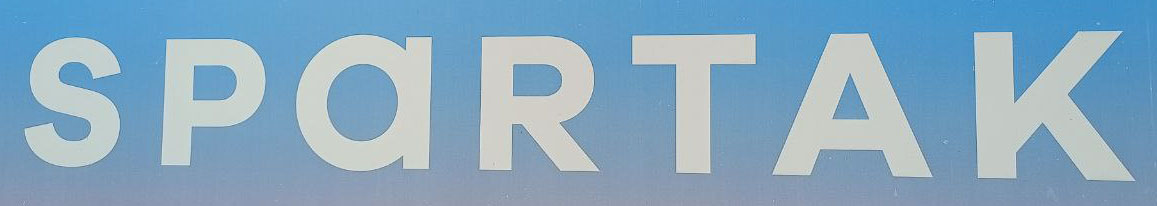

In [16]:
test_image_2='Test.jpg'
Image(test_image_2)

In [17]:
single_image_Prediction(model,test_image_2)

1/1 [==============================] - 0s 82ms/step
Predicted Text in the Image:  SPARTAK
Time Taken for Processing:  0:00:00.141129


In [18]:
test_image_3='Test_Data/48_SCHOOLBOY.jpg'
Image(test_image_3)

In [19]:
single_image_Prediction(model,test_image_3)

1/1 [==============================] - 0s 72ms/step
Predicted Text in the Image:  SCHOOLBOY
Time Taken for Processing:  0:00:00.126116


Перевірка на багатьох картинках

In [20]:
test_img_paths=test_data['ImageName'].values
test_img_labels=test_data['Labels'].values
total = 150

In [21]:
multiple_image_Prediction(model, test_img_paths, test_img_labels, total)

1/1 [==============================] - 0s 79ms/step
--------------------------------------------------------------------------------
Actual Text:  SLINKING    Predicted Text:  SLINKING
1/1 [==============================] - 0s 122ms/step
--------------------------------------------------------------------------------
Actual Text:  REMODELERS    Predicted Text:  REMODELERS
1/1 [==============================] - 0s 67ms/step
--------------------------------------------------------------------------------
Actual Text:  CHRONOGRAPHS    Predicted Text:  CHNONOGRAPHS
1/1 [==============================] - 0s 60ms/step
--------------------------------------------------------------------------------
Actual Text:  IMPEACHING    Predicted Text:  IMPEACHING
1/1 [==============================] - 0s 60ms/step
--------------------------------------------------------------------------------
Actual Text:  LOOTS    Predicted Text:  LOOTS
1/1 [==============================] - 0s 56ms/step
------------